# **LSTM을 이용한 로이터 데이터 분석**

### **로이터 데이터**
- 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋.
- 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많음.
- 각 토픽마다 훈련 세트에 최소한 10개의 샘플이 존재.
- 각 샘플은 (입력값, 출력값)으로 이루어져 있으며 입력값은 정수 변환된 단어 리스트, 출력값은 0~45 중 하나의 정수. 
- LSTM을 활용해서 46가지 다중분류 모형을 만들어보자.








In [ ]:
from tensorflow.keras.datasets import reuters
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SimpleRNN             # embedding" 원핫인코딩을 저차원의 벡터로 바꿔줄 때
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### **데이터 불러오기**
- num_word=1000 매개변수는 데이터에서 가장 자주 등장하는 단어 상위 1,000개로 제한한다는 뜻.
- test_split=0.2 매개변수는 전체 데이터 중 80\%는 학습 데이터로, 나머지 20\%는 시험 데이터로 사용한다는 뜻.
- seed=123 매개변수는 학습 데이터, 시험 데이터를 랜덤하게 나눌 때 필요한 랜덤 시드를 123으로 사용한다는 뜻.

In [21]:
## Reuters data set 불러오기
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2, seed=123)

In [22]:
X_valid, y_valid = X_train[7000:], y_train[7000:]
X_train, y_train = X_train[:7000], y_train[:7000]

# **탐색적 데이터 분석 1. (Exploratory Data Analysis)**
### **데이터 들여다보기**
- 학습 데이터는 8,982개, 시험 데이터는 2,246개의 샘플로 이루어져 있음.
- 학습 데이터를 다시 7,000개, 1,982개로 나누어 각각을 학습 데이터, 평가 데이터로 사용.
- 각 샘플은 정수 리스트. 아래 코드에는 첫 번째 훈련 샘플을 보여주고 있음. 여기서, 각 정수는 vocabulary set에 몇 번째 있는 단어인지를 의미함. 
- 출력 변수는 0~45의 46가지 정수 중 하나를 가짐. 아래 코드는 첫 번째부터 열 번째까지 훈련 샘플의 출력값을 보여주고 있음. 

In [23]:
## 데이터 들여다보기
print('Number of train samples: %d'%len(X_train))
print('Number of test samples: %d'%len(X_test))
print('An example of the reuters data set')
print('...Input sample')
print(X_train[0])    #1000개의 토큰 고려, 수많은 단어들을 정수로 바꿔진 (n)번째 단어들로 나열되어 있음
print(len(X_train[0]))
print('...Output samples (46)') 
print(y_train[0:10])            # 1번째 기사의 토픽은 5번째, 2번째 기사도 5번째, 3번째 기사는 20번째 토픽
print('Number of categories: %d'%(y_test.max()+1))

Number of train samples: 7000
Number of test samples: 2246
An example of the reuters data set
...Input sample
[1, 599, 2, 9, 2, 764, 2, 56, 2, 2, 8, 25, 2, 61, 20, 324, 323, 56, 2, 2, 2, 200, 6, 264, 342, 2, 2, 9, 2, 2, 56, 2, 22, 56, 2, 71, 10, 2, 176, 487, 6, 658, 231, 783, 51, 8, 775, 5, 2, 34, 69, 251, 11, 599, 505, 2, 4, 2, 2, 2, 7, 4, 2, 9, 2, 2, 17, 12]
68
...Output samples (46)
[ 4  4 19 25 22  3  3  3  3  3]
Number of categories: 46


# **탐색적 자료 분석 2.**
### **단어 수에 대한 히스토그램 그려보기**
- 훈련자료 각각의 샘플은 몇 개의 단어로 이루어져 있는지 한 눈에 알아보기 위한 작업.
- 히스토그램을 이용해서 샘플 별 단어 수의 분포를 확인할 수 있음.

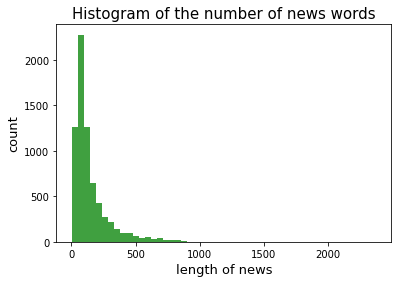

In [24]:
## 뉴스의 단어 수에 대한 히스토그램 그려보기
plt.figure(figsize=(6,4))
n, bins, patches = plt.hist(np.hstack([len(x) for x in X_train]), 50, facecolor='g', alpha=0.75)     
plt.xlabel('length of news', fontsize=13)
plt.ylabel('count', fontsize=13)
plt.title('Histogram of the number of news words', fontsize=15)
plt.show()

# **탐색적 자료 분석 3.** 
### **각 토픽 레이블에 대한 도수 분포표 만들어보기.**
- 각 레이블 별로 몇 개 씩의 샘플이 존재하는지 도수 분포표를 만들어볼 수 있음.
- class 3,4가 가장 많은 도수를 가지고 있는 것을 확인할 수 있음.

In [25]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)           # y_train에 있는 벡터, 0부터 45까지 카테고리에 몇개의 빈도가 있는지/
print("각 레이블에 대한 빈도수:")
print(np.vstack((unique_elements, counts_elements)))   # 행렬로 만들어줌.  0이라고 하는 것은 44번, 1번의 카테고리는 312번 

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  44  312   59 2489 1502   14   39   13  112   79   87  289   46  140
    18   19  341   32   53  410  229   85   14   32   46   87   22   10
    38   16   30   36   25   13   33    8   33   16   10   14   33   22
    11   16   13   10]]


# **탐색적 자료 분석 4.**
### **Vocabulary set을 이용하여 정수 입력값을 단어로 치환하기**
- Vocabulary set은 파이썬의 dictionary 형식으로 이루어져 있음. 
- \{단어0: 0, 단어1: 1, ...\} (여기서 단어는 key, 정수는 value)
- 번호에 맞는 단어를 출력하기 위해서는 dictionary의 key와 value의 순서를 바꾸어야 함.
- 아래 코드는 정수를 key로, 단어를 keyword로 바꾸는 작업.
- 이렇게 변환된 vocabulary set을 이용해서 빈도수가 높은 단어들을 살펴볼 수 있음. (해당 코드는 상위 5번째 빈출 단어를 출력하도록 하고 있음.)
- 첫 번째 문장을 단어로 바꿔서 출력해볼 수 있음. 
- 해당 데이터는 형태소 분석을 통해 정제한 데이터이기 때문에 문장이 매끄럽게 이어지지 않는 것을 확인할 수 있음. 

In [26]:
word_to_index = reuters.get_word_index()
index_to_word = {}

## switching key and value in dictionary
for key, value in word_to_index.items():
    index_to_word[value] = key

## 빈도수 index번째 단어 살펴보기
index=5
print('빈도수 상위'+str(index+1)+'번째 단어 : {}'.format(index_to_word[index]))

## 복원된 문장 만들어보기
print(X_train[0])
print(' '.join([index_to_word[s] for s in X_train[0]]))  #형태소 분석이 끝난 애들,,,,, 특수문자, 등 다 제외해서 이게 무슨 뜻인지 알기는 쉽지 않음. 정수로 되어 있는 문장을 실제 문장으로 복원 가능 

550378/550378 [==============================] - 0s 0us/step
빈도수 상위6번째 단어 : said
[1, 599, 2, 9, 2, 764, 2, 56, 2, 2, 8, 25, 2, 61, 20, 324, 323, 56, 2, 2, 2, 200, 6, 264, 342, 2, 2, 9, 2, 2, 56, 2, 22, 56, 2, 71, 10, 2, 176, 487, 6, 658, 231, 783, 51, 8, 775, 5, 2, 34, 69, 251, 11, 599, 505, 2, 4, 2, 2, 2, 7, 4, 2, 9, 2, 2, 17, 12]
the least of 3 of 95 of 6 of of mln at of had is half company's 6 of of of imports and based so of of 3 of of 6 of its 6 of profit for of official reagan and selling american east last mln france said of u 9 before vs least losses of in of of of a in of 3 of of pct dlrs


# **LSTM을 이용한 데이터 분석 1.**
### **LSTM의 입력값 형태에 맞도록 입력값 데이터 변환하기**
#### 미니배치의 sample이 다르기 때문에 필요함

- LSTM 모형은 정해진 길이의 문장을 입력값으로 받을 수 있음.
- 로이터 데이터셋은 샘플마다 다른 길이의 문장이므로 이를 통일시켜야 함.
- 해당 코드에서는 100개의 단어를 갖는 문장으로 통일. 
- Max_len: 뉴스를 구성하는 최대 단어 수.
- 100개 미만의 단어로 이루어진 문장은 앞에 0을 넣어서 100차원으로 맞춰주고, 100개가 넘는 단어로 이루어진 문장은 앞 100개의 단어만 사용함.

### **LSTM의 출력값 형태에 맞도록 출력값 데이터 변환하기**
- 0~45 사이의 정수값을 46차원의 one-hot vector로 바꾸어줌.

In [ ]:
## 뉴스를 구성하는 단어의 수 일치시키기.
max_len = 100  ## 최대 100개

pad_X_train = pad_sequences(X_train, maxlen=max_len) # train set
pad_X_valid = pad_sequences(X_valid, maxlen=max_len) # valid set
pad_X_test = pad_sequences(X_test, maxlen=max_len)   # test set

print(X_train[0])
print(pad_X_train[0])

## one hot coding
oh_y_train = to_categorical(y_train) # train set
oh_y_valid = to_categorical(y_valid) # valid set 
oh_y_test = to_categorical(y_test)   # test set

print(y_train[0])
print(oh_y_train[0])

[1, 599, 2, 9, 2, 764, 2, 56, 2, 2, 8, 25, 2, 61, 20, 324, 323, 56, 2, 2, 2, 200, 6, 264, 342, 2, 2, 9, 2, 2, 56, 2, 22, 56, 2, 71, 10, 2, 176, 487, 6, 658, 231, 783, 51, 8, 775, 5, 2, 34, 69, 251, 11, 599, 505, 2, 4, 2, 2, 2, 7, 4, 2, 9, 2, 2, 17, 12]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 599   2   9
   2 764   2  56   2   2   8  25   2  61  20 324 323  56   2   2   2 200
   6 264 342   2   2   9   2   2  56   2  22  56   2  71  10   2 176 487
   6 658 231 783  51   8 775   5   2  34  69 251  11 599 505   2   4   2
   2   2   7   4   2   9   2   2  17  12]
4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# **LSTM을 이용한 데이터 분석 2.**
### **1-layered RNN와 1-layered LSTM 모델 구축하기**
- Embedding 함수에서 1,000은 단어의 가지수를 뜻함. 처음 로이터 데이터를 불러왔을 때 빈도수 기준 1,000가지의 단어만을 가져왔기 때문에 1000으로 설정. 이를 100차원으로 차원 축소.
- 100차원으로 축소한 벡터에 RNN 및 LSTM을 이용하여 모델을 만듦.
- 해당 코드에서는 RNN, LSTM 모두 100차원의 hidden layer가 만들어지도록 설계.
- 추가로 층을 더 쌓고 싶으면 아래 주석처리한 코드를 추가하면 됨.
- 마지막에는 출력값을 예측해야 하므로 46차원의 layer를 한 단 쌓고, softmax를 이용하여 조건부 확률을 출력하게 함.
- 목적함수는 Cross Entropy, 최적화 알고리즘은 Adam을 사용.
- Mini-batch size는 100으로 정하고, 20 epoch 동안 학습.
- 학습 시 학습 데이터의 10\%는 평가 데이터로 이용.
- **과제 3에서는 hidden layer의 개수, 각 hidden layer마다의 노드 수, 최적화 방법 등을 바꾸어가면서 실험하면 됩니다.**


In [ ]:
## 1-layered rnn
rnn = Sequential()
rnn.add(Embedding(1000, 100))     # 단어 인코딩한 1000차원짜리 단어를, 100차원으로 embedding  : 벡터는 추정
#rnn.add(SimpleRNN(100, return_sequences = True, activation='tanh'))   # return_sequences parameter has to be set True to stack
rnn.add(SimpleRNN(100, return_sequences = False, activation='tanh'))      # h는 100개의 노드, return_sequences = False : 1000차우너 -> 100차우너 인배딩./ rmm 1단 갈고... 최상단이 아니면 return_sequences = True, /마지막이면 False
rnn.add(Dense(46, activation = 'softmax'))

## 1-layered lstm
lstm = Sequential()
lstm.add(Embedding(1000, 100))
#lstm.add(LSTM(100, return_sequences=True, activation='tanh'))
lstm.add(LSTM(100, activation='tanh'))
lstm.add(Dense(46, activation = 'softmax'))

## model compile
rnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
lstm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## start training
rnn_history = rnn.fit(pad_X_train, oh_y_train, batch_size = 100, epochs = 20, validation_data=(pad_X_valid, oh_y_valid))
lstm_history = lstm.fit(pad_X_train, oh_y_train, batch_size = 100, epochs = 20, validation_data=(pad_X_valid, oh_y_valid))


Epoch 1/20
70/70 [==============================] - 6s 73ms/step - loss: 2.5725 - accuracy: 0.3191 - val_loss: 2.3599 - val_accuracy: 0.3577
Epoch 2/20
70/70 [==============================] - 5s 70ms/step - loss: 2.2903 - accuracy: 0.3851 - val_loss: 2.1934 - val_accuracy: 0.4253
Epoch 3/20
70/70 [==============================] - 5s 72ms/step - loss: 2.1145 - accuracy: 0.4707 - val_loss: 2.0967 - val_accuracy: 0.4501
Epoch 4/20
70/70 [==============================] - 5s 72ms/step - loss: 1.8678 - accuracy: 0.5270 - val_loss: 1.8814 - val_accuracy: 0.5091
Epoch 5/20
70/70 [==============================] - 5s 70ms/step - loss: 1.6603 - accuracy: 0.5820 - val_loss: 2.0001 - val_accuracy: 0.4773
Epoch 6/20
70/70 [==============================] - 5s 72ms/step - loss: 1.4891 - accuracy: 0.6313 - val_loss: 1.9600 - val_accuracy: 0.5474
Epoch 7/20
70/70 [==============================] - 5s 70ms/step - loss: 1.3759 - accuracy: 0.6591 - val_loss: 1.8060 - val_accuracy: 0.5484
Epoch 8/20
70

# **LSTM을 이용한 데이터 분석 3.**
### **학습 데이터, 평가 데이터, 시험 데이터에서의 분류 정확도 확인하기**
- RNN과 LSTM의 분류 정확도를 확인하자.
- Epoch 별로 학습 데이터와 평가 데이터에서의 분류 정확도를 그림으로 그려보자.
- 20 epoch에서의 시험 데이터를 이용한 분류 정확도를 구해보자.

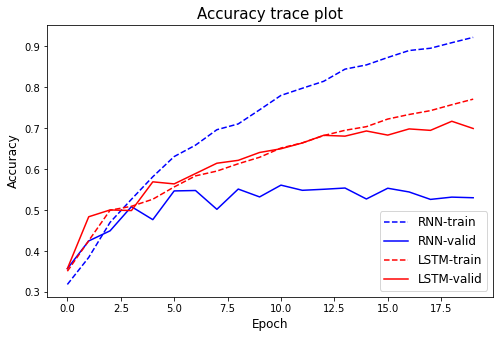

71/71 [==============================] - 0s 5ms/step - loss: 1.3106 - accuracy: 0.6870
Test data results
...RNN accuracy: 0.515, loss: 2.563
...LSTM accuracy: 0.687, loss: 1.311


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(rnn_history.history['accuracy'], 'b--', label='RNN-train')
plt.plot(rnn_history.history['val_accuracy'], 'b-', label='RNN-valid')
plt.plot(lstm_history.history['accuracy'], 'r--', label='LSTM-train')
plt.plot(lstm_history.history['val_accuracy'], 'r-', label='LSTM-valid')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

rnn_results = rnn.evaluate(pad_X_test, oh_y_test)
lstm_results = lstm.evaluate(pad_X_test, oh_y_test)
print('Test data results')
print('...RNN accuracy: %.3f, loss: %.3f'%(rnn_results[1], rnn_results[0]))
print('...LSTM accuracy: %.3f, loss: %.3f'%(lstm_results[1], lstm_results[0]))